# ChebGCNs 


Spectral Graph ConvNets<br>
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering<br>
M Defferrard, X Bresson, P Vandergheynst<br>

DOC : https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=cheb#dgl.nn.pytorch.conv.ChebConv

In [1]:
import os
import sys
import time
import numpy as np

# -------------Torch-------------------
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# -------------Graph-------------------
import dgl
import networkx as nx
import matplotlib.pyplot as plt

from utils import set_device
from laplacian import normalized_laplacian

# os.environ['KMP_DUPLICATE_LIB_OK']='True'

sys.path.insert(0, "lib/")
%load_ext autoreload
%autoreload 2

In [2]:
# GPU Compatibility
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = set_device(verbose=True)

cuda not available


# MNIST

In [3]:
# Downloads the dataset if not found locally
from Dataset import check_mnist_dataset_exists, datasampler, MNISTDataset

_ = check_mnist_dataset_exists()

nb_selected_train_data = 640
nb_selected_test_data = 200

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data, nb_selected_test_data
)

In [4]:
trainset = MNISTDataset(train_data, train_labels)
testset = MNISTDataset(test_data, test_labels)

## Convolution layer and classifier


In [5]:
from model import Classifier, SanityCheck

In [6]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label, signal).
    graphs, labels, signals = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels),  torch.stack(signals).view(-1)

# Debug section
Verifying all of the steps

-------------------- Network model --------------------
 Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=5, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=160, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)
L tensor(indices=tensor([[  0,   0,   0,  ..., 783, 783, 783],
                       [  0,   1,  28,  ..., 755, 782, 783]]),
       values=tensor([-1.3323e-15, -4.0825e-01, -4.0825e-01,  ...,
                      -4.0825e-01, -4.0825e-01, -1.3323e-15]),
       size=(784, 784), nnz=3808, layout=torch.sparse_coo) size: 784 time 0.02928614616394043 



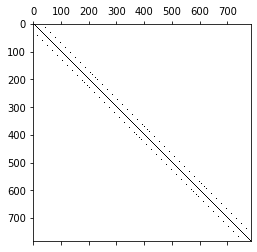

In [7]:
g, l, s = trainset[0]

# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 5
n_classes = trainset.num_classes

net2 = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
).to(device)
print("-------------------- Network model --------------------\n", net2)

t = time.time()
# Calculate L
g.to(device)
L = normalized_laplacian(g)
print("L", L, "size:", len(L), "time", time.time() - t,'\n')
plt.spy(L.to_dense())

In [8]:
print("\n --------------------  Output for graph g:  --------------------\n", net2(g, s, L))


 --------------------  Output for graph g:  --------------------
 tensor([[-0.0477,  0.0183,  0.0453, -0.0215, -0.0076,  0.0214,  0.0516, -0.0279,
          0.0068,  0.0978]], grad_fn=<AddmmBackward>)




# Model definition for training

In [9]:
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = trainset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Training pipe

In [10]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=64,
                         shuffle=True, collate_fn=collate)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

epoch_losses = []

## Training time

One Prediction:
 tensor([ 4.2116, -6.8962,  2.8909,  4.3815,  2.5151, 10.6581, -0.2412, -4.7338,
         7.3642,  4.9743], grad_fn=<SelectBackward>) len: torch.Size([64, 10]) 
 label: tensor(5)
Epoch 0, loss 0.3209, in 58.76(s) 
One Prediction:
 tensor([ 1.3301,  0.7881,  1.2356, -2.0513,  2.4521,  1.9920, 10.5185,  0.5268,
        -0.2069,  1.9534], grad_fn=<SelectBackward>) len: torch.Size([64, 10]) 
 label: tensor(6)
Epoch 1, loss 0.2173, in 62.96(s) 
One Prediction:
 tensor([21.6581, -7.4276, -6.1375,  1.1668, -1.2725, 13.3686,  4.0620, -7.0713,
        -3.0999,  0.4220], grad_fn=<SelectBackward>) len: torch.Size([64, 10]) 
 label: tensor(0)
Epoch 2, loss 0.1636, in 70.87(s) 
One Prediction:
 tensor([12.1358, -3.2699, 17.9352,  3.8591,  0.9242, 11.6282, -0.2153, -6.9095,
         3.2404, -2.7168], grad_fn=<SelectBackward>) len: torch.Size([64, 10]) 
 label: tensor(2)
Epoch 3, loss 0.0872, in 71.17(s) 
One Prediction:
 tensor([-7.7405, -2.6708, -4.2766, -2.1308,  1.1639, -6.5029, -

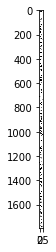

In [17]:
from laplacian import normalized_laplacian
net.train()

for epoch in range(5):
    epoch_loss = 0
    t0 = time.time()
    for iter, (bg, label, signal) in enumerate(data_loader):
        if iter == 0:
            L = normalized_laplacian(bg).to(device)
            t = time.time()
            #print('\n THIS /!\ \n')
            plt.imshow(signal.view(-1, 28), cmap='gray_r')

        if torch.cuda.is_available():
            bg.to(device)

        prediction = net(bg, signal, L)

        if iter == 0:
            #print("prediction time:", time.time() - t)
            t = time.time()
            print("One Prediction:\n", prediction[0], 'len:',
                  prediction.size(), '\n label:', label[0])  # DEBUG
        loss = loss_func(prediction, label.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach().item()

    epoch_loss /= iter + 1
    print(
        "Epoch {}, loss {:.4f}, in {:.2f}(s) ".format(
            epoch, epoch_loss, time.time() - t0
        )
    )
    epoch_losses.append(epoch_loss)

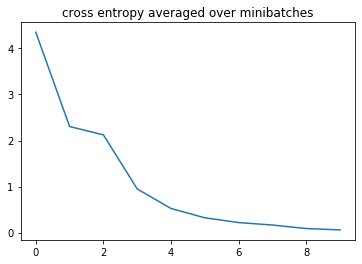

In [18]:
plt.title("cross entropy averaged over minibatches")
plt.plot(epoch_losses)
plt.show()

In [19]:
torch.cuda.empty_cache()

## Test Metrics

In [20]:
# Change

net.eval()
# Convert a list of tuples to two lists
test_X, test_Y, test_S = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
L = normalized_laplacian(test_bg)
test_S = torch.stack(test_S).view(-1)
probs_Y = torch.softmax(net(test_bg,test_S, L), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(
    "Accuracy of sampled predictions on the test set: {:.4f}%".format(
        (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100
    )
)
print(
    "Accuracy of argmax predictions on the test set: {:4f}%".format(
        (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100
    )
)

Accuracy of sampled predictions on the test set: 90.0000%
Accuracy of argmax predictions on the test set: 92.500000%


In [21]:
# BATCHED DGL EXAMPLE
import sklearn
from sklearn.metrics import classification_report

print(sklearn.metrics.classification_report(test_Y, argmax_Y))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        17
         1.0       1.00      1.00      1.00        28
         2.0       0.82      0.88      0.85        16
         3.0       0.94      1.00      0.97        16
         4.0       0.93      0.89      0.91        28
         5.0       1.00      0.95      0.97        20
         6.0       0.90      0.95      0.93        20
         7.0       0.84      0.88      0.86        24
         8.0       1.00      1.00      1.00        10
         9.0       0.89      0.76      0.82        21

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.92       200



## Saving

In [22]:
from utils import save_model

save_model("Model_firstWorking", net)